# Introduction to SHAP for explaining regression models
## CHAPTER 06 - *Introduction to model interpretability using SHAP*

From **Applied Machine Learning Explainability Techniques** by [**Aditya Bhattacharya**](https://www.linkedin.com/in/aditya-bhattacharya-b59155b6/), published by **Packt**

### Objective

In this notebook, let us get familiar with the SHAP (SHapley  Additive exPlanation) framework for explaining regression models, based on the concepts discussed in Chapter 6 - Introduction to model interpretability using SHAP.

### Installing the modules

Install the following libraries in Google Colab or your local environment, if not already installed.

In [ ]:
!pip install --upgrade pandas numpy matplotlib seaborn scikit-learn shap

### Loading the modules

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
np.random.seed(123)
import seaborn as sns
import matplotlib.pyplot as plt

import shap
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor

In [40]:
import matplotlib
matplotlib.__version__

'3.5.1'

### About the data

**Red Wine Quality Dataset - Kaggle**

The dataset is related to the red variant of the Portuguese "Vinho Verde" wine. For more details, consult the reference [Cortez et al., 2009]. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.). We will use this dataset for solving a regression problem.

**Citation** -
*P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties.
In Decision Support Systems, Elsevier, 47(4):547-553, 2009.*

- Original Source - https://archive.ics.uci.edu/ml/datasets/wine+quality
- Kaggle Source - https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009 


### Loading the data

In [2]:
# We will read the training data
data = pd.read_csv('dataset/winequality-red.csv')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
data.shape

(1599, 12)

In [4]:
data.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [6]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Now that we see that our dataset has 10 features with all float values, we do not need to do any encoding of features. We can do data normalization for getting more accurate models. But our focus is on the model interpretability part using SHAP. So, we will skip the EDA and normalization part and build a simple ML model which might not be very accurate using the Random Forest algorithm. We still need to check for missing values, as a dataset with missing values can cause problems later.

In [7]:
# Dropping missing values
data.fillna(0,inplace=True)
data.shape

(1599, 12)

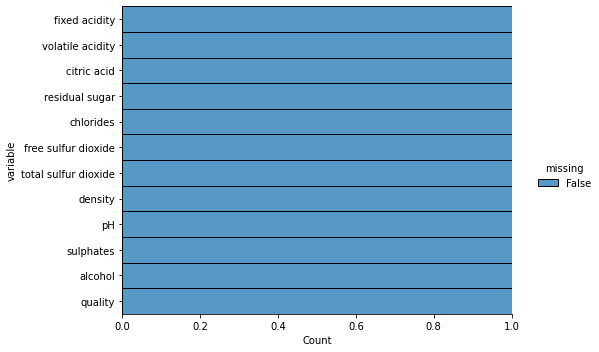

In [8]:
# Handling missing values
sns.displot(
    data=data.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.5
)
plt.show()

No missing values found in the data. We can proceed with the model training process.

### Training the model

In [9]:
features = data.drop(columns=['quality'])
labels = data['quality']
# Dividing the data into training-test set with 80:20 split ratio
x_train,x_test,y_train,y_test = train_test_split(features,labels,test_size=0.2, random_state=123)

In [10]:
model = RandomForestRegressor(n_estimators=2000, max_depth=30, random_state=123)
model.fit(x_train, y_train)

RandomForestRegressor(max_depth=30, n_estimators=2000, random_state=123)

In [11]:
model.score(x_test, y_test)

0.49976030471036337

The coefficient of determination ($R^2$ coefficient) is around 0.5. The scores indicate that we do not have a very good ML model. Hence, it is even more important to explain such models. Let's define the prediction probability function (*f*) now, which we will used by the SHAP framework.

### Using SHAP for model interpretability

In [76]:
explainer = shap.Explainer(model)
shap_values = explainer(x_test)

### Model interpretability using SHAP visualizations

#### Global interpretability with feature importance

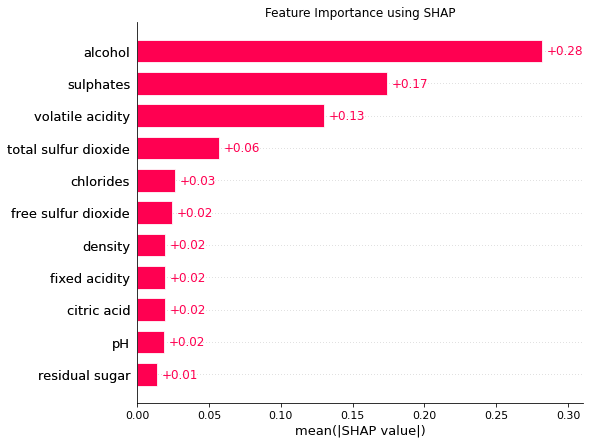

In [26]:
plt.title('Feature Importance using SHAP')
shap.plots.bar(shap_values, show=True, max_display=12)

#### Global interpretability with heatmap plots

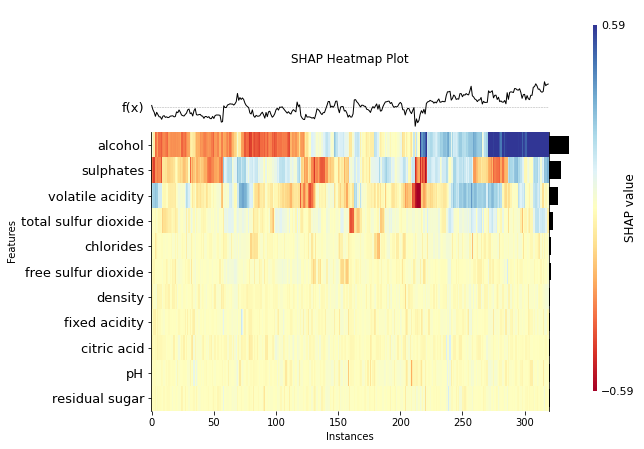

In [59]:
plt.title('SHAP Heatmap Plot')
shap.plots.heatmap(shap_values, max_display=12, cmap = 'RdYlBu', show=False)
plt.gcf().axes[-1].set_box_aspect(100)
plt.ylabel('Features')
plt.show()

#### Global interpretability with Cohort plots

**Please note** - #TO-DO- Mention about issue with the SHAP framework's with version number, which is solved in https://github.com/slundberg/shap/issues/2325
; https://github.com/yuuuxt/shap/commit/7c95fd2b48bcf9cad82b10f65e552a49b360afbd

In [15]:
# index of the feature alcohol is 10
f_idx = 10
alcohol = ["High Alcohol" if shap_values[i].data[f_idx] >=10.0 else "Low Alcohol" for i in range(shap_values.shape[0])]

In [16]:
shap_values.cohorts(alcohol).abs.mean(0)

<shap._explanation.Cohorts object with 2 cohorts of sizes: [(11,), (11,)]>

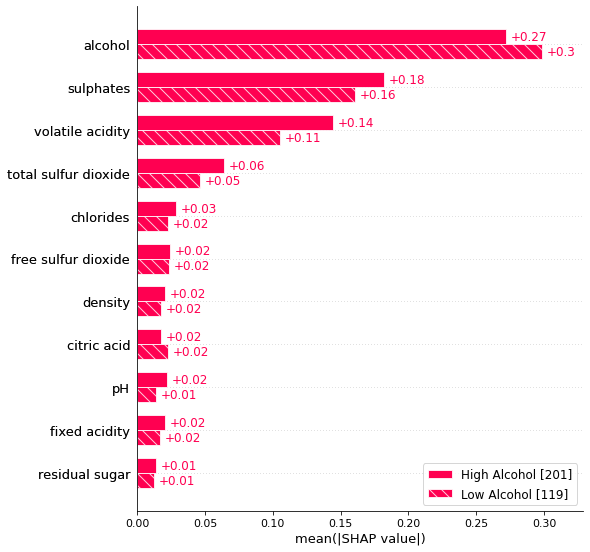

In [17]:
shap.plots.bar(shap_values.cohorts(alcohol).abs.mean(0), max_display=12)

#### Global interpretability with feature clustering

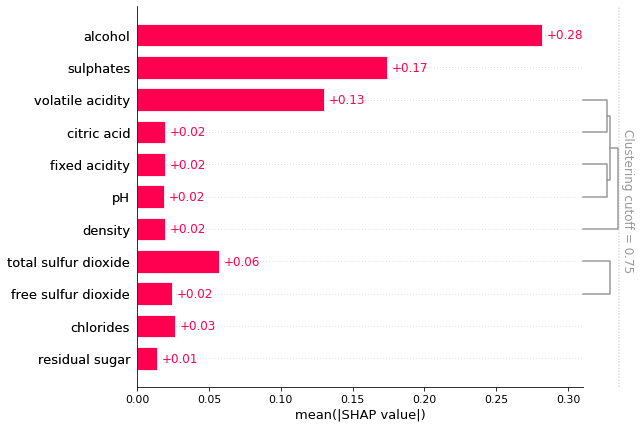

In [33]:
clustering = shap.utils.hclust(x_test, y_test)
shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=0.75, max_display = 12)

#### Global interpretability with feature clustering

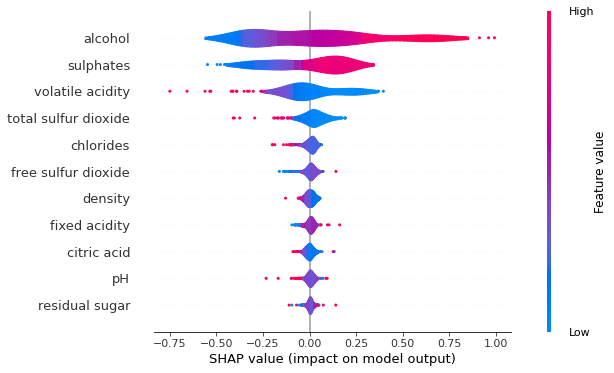

In [51]:
shap.summary_plot(shap_values, x_test, plot_type="violin", show=False)
plt.gcf().axes[-1].set_box_aspect(10)
plt.show()

#### Global interpretability with feature dependence plot

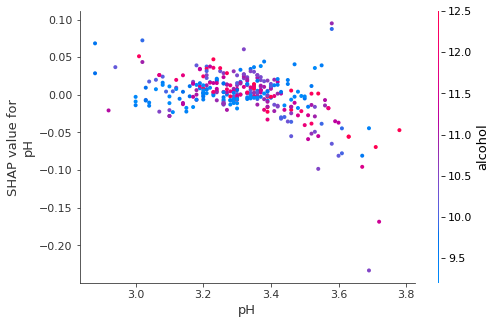

In [81]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test)
shap.dependence_plot("pH", shap_values, x_test, show=False)
plt.gcf().axes[-1].set_box_aspect(50)

#### Local interpretability with force plot

In [83]:
# Initialization of javascript visualization in notebooks
shap.initjs()

In [91]:
shap.force_plot(explainer.expected_value, shap_values[0,:], x_test.iloc[0,:], plot_cmap="PkYg")

#### Local interpretability using Waterfall plots

 99%|===================| 318/320 [03:19<00:01]        

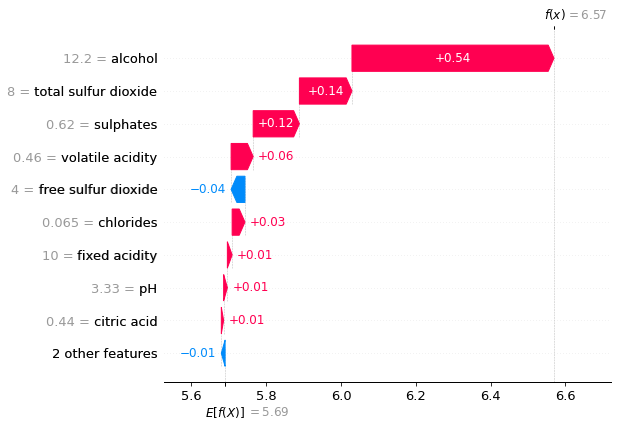

In [98]:
explainer = shap.Explainer(model, x_test)
shap_values = explainer(x_test)
shap.plots.waterfall(shap_values[0]) # For the first observation

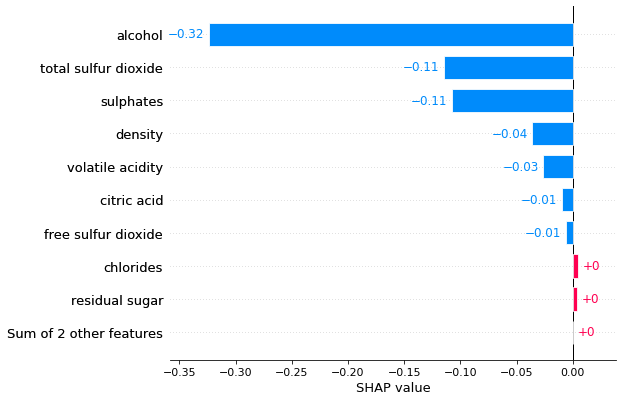

In [94]:
# Similarly for the second observation
shap.plots.bar(shap_values[1]) 

#### Local interpretability with decision plot

100%|===================| 319/320 [04:10<00:00]        

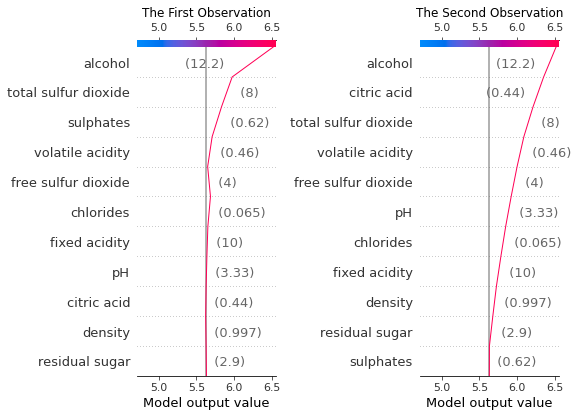

In [99]:
figure = plt.figure(figsize=(10,5))
ax1 = figure.add_subplot(121)
shap_values = explainer.shap_values(x_test)[0]
shap.decision_plot(expected_value, shap_values, x_test, show=False)
ax1.title.set_text('The First Observation')

ax2 = figure.add_subplot(122)
shap_values = explainer.shap_values(x_test)[5]
shap.decision_plot(expected_value, shap_values, x_test, show=False)
ax2.title.set_text('The Second Observation')
plt.tight_layout()
plt.show()

## Final Thoughts

## Reference

1. Red Wine Quality Dataset - Kaggle - https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009
4. Some of the utility functions and code are taken from the GitHub Repository of the author - Aditya Bhattacharya https://github.com/adib0073